In [1]:
!pip install contextily
!pip install geopandas
!pip install seaborn
!pip install networkx[default]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 32.1 MB/s eta 0:00:00


In [44]:
import pandas as pd
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from geopy.distance import great_circle
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/talentoTech/proyectoDeforestacion/AREAS_DEFORESTADAS_CHOCO_20240608.csv')
head = data.head()
head

,ID,TIPO GEOMETRIA,AÑO,IMAGEN,CAUSA,AREA_Ha,OBSERVACION,LATITUD,LONGITUD,MUNICIPIO
0,7463,Polygon,2020,T18PTQ_20200201T153611_TCI_10m.jp2 - T18PTQ_20...,Cultivo,0.126512,Ninguna,"8° 22' 43,726"" N","77° 14' 19,019"" W",ACANDÍ
1,4659,Polygon,2019,T18PTQ_20190527T153621_TCI_10m.jp2 - T18PTQ_20...,Cultivo,0.140720,Ninguna,"8° 30' 47,551"" N","77° 19' 30,507"" W",ACANDÍ
2,7459,Polygon,2020,T18PTQ_20200112T153611_TCI_10m.jp2 - T18PTQ_20...,Cultivo,0.141250,Ninguna,"8° 22' 30,966"" N","77° 13' 49,720"" W",ACANDÍ
3,9719,Polygon,2021,T18PTQ_20201202T153619_TCI_10m.jp2 - T18PTQ_20...,Cultivo,0.158066,Ninguna,"8° 36' 11.256"" N","77° 20' 50.757"" W",ACANDÍ
4,7464,Polygon,2020,T18PTQ_20200201T153611_TCI_10m.jp2 - T18PTQ_20...,Cultivo,0.184549,Ninguna,"8° 22' 22,008"" N","77° 14' 3,921"" W",ACANDÍ


In [45]:
# Mapa de calor - Distribución geográfica de la deforestación

def dms_to_decimal(dms_str):
    """Convert DMS (degrees, minutes, seconds) to decimal format, handling N/S/E/W directions."""
    try:
        if pd.notnull(dms_str):
            dms_str = str(dms_str).strip()  # Convert to string and strip whitespace
            parts = dms_str.replace('°', '').replace("'", '').replace('"', '').replace(',', '.').split()

            # Verificación del número de partes y la dirección
            if len(parts) == 4:
                degrees = float(parts[0])
                minutes = float(parts[1]) / 60
                seconds = float(parts[2]) / 3600
                direction = parts[3]

                decimal = degrees + minutes + seconds
                if direction in ['S', 'W']:
                    decimal = -decimal
                return decimal
            else:
                raise ValueError(f"Formato de coordenadas inválido: {dms_str}")
        else:
            return None
    except Exception as e:
        print(f"Error en la conversión: {e}")
        return None


df = data.copy()
df = data[data['MUNICIPIO'] == "ACANDÍ"]
df.reset_index(drop=True, inplace=True)
df['LATITUD'].dropna(inplace=True)
df['LONGITUD'].dropna(inplace=True)
# Aplicar la función de conversión a las columnas de latitud y longitud

df['LATITUD'] = df['LATITUD'].apply(dms_to_decimal)
df['LONGITUD'] = df['LONGITUD'].apply(dms_to_decimal)

# Filtrar filas con coordenadas nulas (conversiones fallidas)
df = df.dropna(subset=['LATITUD', 'LONGITUD'])


<ipython-input-45-1003500d9ca2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LATITUD'].dropna(inplace=True)
<ipython-input-45-1003500d9ca2>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LONGITUD'].dropna(inplace=True)
<ipython-input-45-1003500d9ca2>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LATITUD'] = df['LATITUD'].apply(dms_to_decimal)
<ipython-inpu

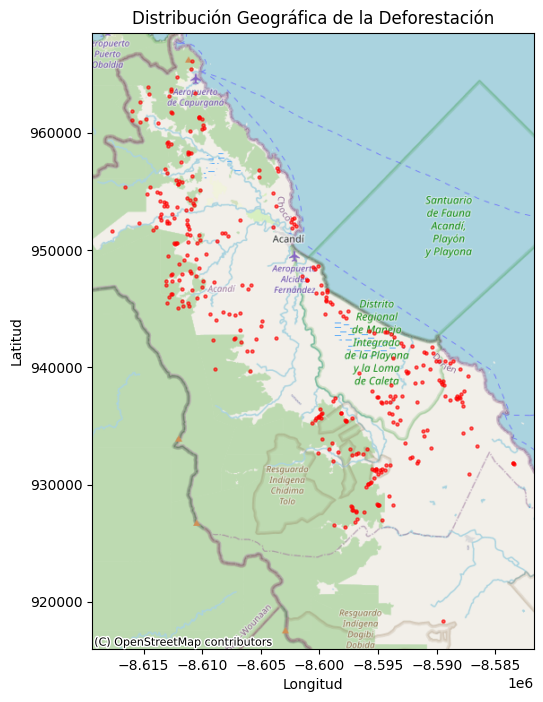

In [22]:
# Convertir a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUD, df.LATITUD))
gdf = gdf.set_crs(epsg=4326)  # Establecer el CRS a WGS84
gdf = gdf.to_crs(epsg=3857)  # Convertir a Web Mercator para contextily

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Añadir puntos al gráfico
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.6)

# Añadir mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Títulos y etiquetas
plt.title('Distribución Geográfica de la Deforestación')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()

In [50]:
data = df

# Crear un grafo
G = nx.Graph()

# Añadir nodos y posiciones
positions = {}
for i, row in data.iterrows():
    pos = (row['LATITUD'], row['LONGITUD'])
    G.add_node(i, pos=pos)
    positions[i] = pos
# Convertir posiciones a una lista
coords = list(positions.values())

# Configurar el modelo de k-vecinos más cercanos
k = 10  # Número de vecinos más cercanos
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Añadir bordes basados en los vecinos más cercanos
for i, idx in enumerate(indices):
    for j in idx:
        if i != j:  # Evitar auto-conexiones
            pos_i = positions[i]
            pos_j = positions[j]
            distance = great_circle(pos_i, pos_j).kilometers
            G.add_edge(i, j, weight=distance)

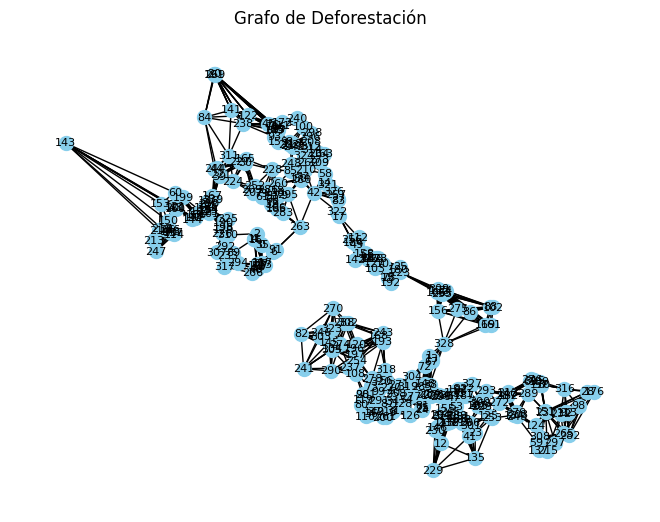

In [51]:
# prompt: quiero visualizar mi grafo graficamente osea G

# Dibujar el grafo
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=8)
plt.title("Grafo de Deforestación")
plt.show()


In [52]:
# Buscar el camino más corto entre dos nodos
shortest_path = nx.shortest_path(G, source=143, target=82, weight='weight')
print("Camino más corto:", shortest_path)


Camino más corto: [143, 60, 199, 164, 62, 136, 39, 224, 252, 286, 260, 280, 42, 322, 17, 112, 162, 10, 223, 166, 156, 328, 13, 304, 271, 320, 278, 237, 305, 82]


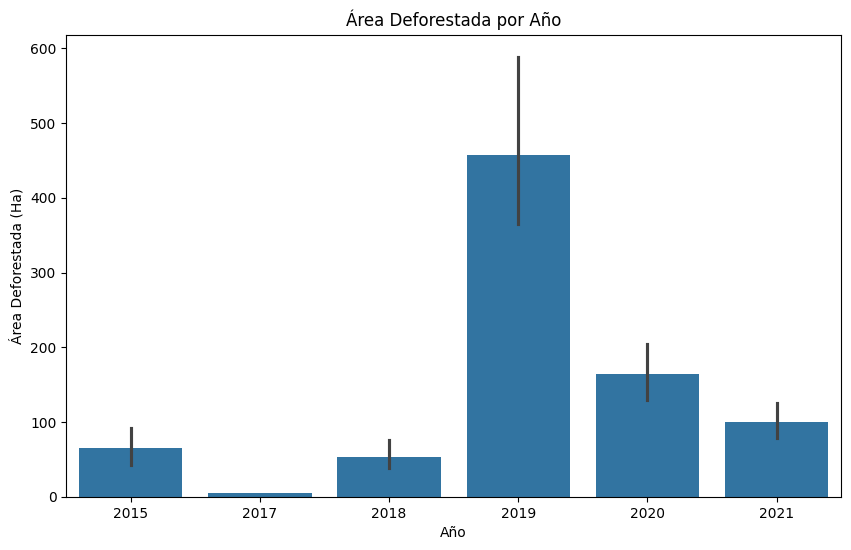

In [29]:
# Gráfico de barras - Área deforestada por año
plt.figure(figsize=(10, 6))
sns.barplot(x='AÑO', y='AREA_Ha', data=data, estimator=sum)
plt.title('Área Deforestada por Año')
plt.xlabel('Año')
plt.ylabel('Área Deforestada (Ha)')
plt.show()

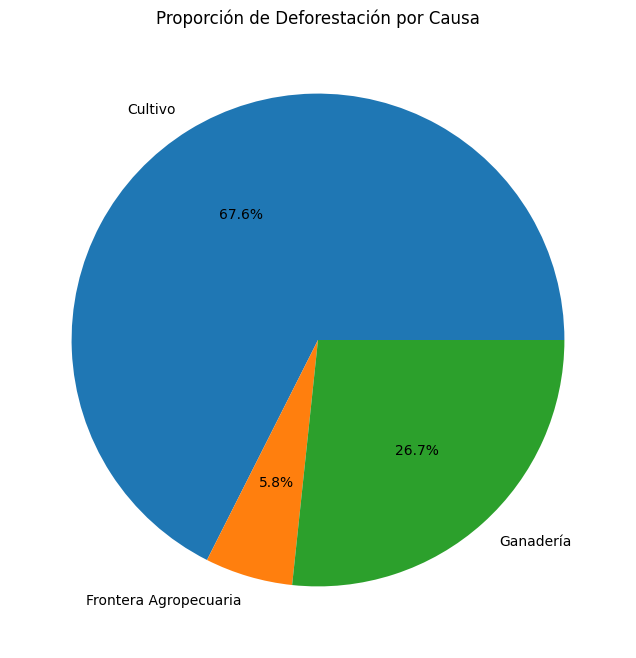

In [30]:
# Gráfico de pastel - Proporción de deforestación por causa
causa_data = data.groupby('CAUSA')['AREA_Ha'].sum()
plt.figure(figsize=(8, 8))
causa_data.plot.pie(autopct='%1.1f%%')
plt.title('Proporción de Deforestación por Causa')
plt.ylabel('')
plt.show()